In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
import numpy as np

In [2]:
df = pd.read_pickle('data/orders_df.pkl')

In [3]:
df = df.sort_values(['branch_id', 'created_at']).reset_index(drop=True)
df['const'] = 1

df['eta_sec'] = (df['committed_time'] - df['created_at']).dt.seconds
df['rta_sec'] = (df['order_status_delivered_time'] - df['created_at']).dt.seconds
df['prep_time_sec'] = (df['order_status_order_ready_time'] - df['created_at']).dt.seconds

df['orders_in_5_min'] = df.groupby('branch_id').rolling('5T', on='created_at')['const'].sum().values
df['orders_in_10_min'] = df.groupby('branch_id').rolling('10T', on='created_at')['const'].sum().values
df['orders_in_15_min'] = df.groupby('branch_id').rolling('15T', on='created_at')['const'].sum().values
df['orders_in_30_min'] = df.groupby('branch_id').rolling('30T', on='created_at')['const'].sum().values

t = (df['prep_time_sec'] < df['prep_time_sec'].quantile(.95)) & (df['prep_time_sec'] > 30) & ~df['is_scheduled']
df = df[t].reset_index(drop=True)

In [4]:
t.sum()

612908

In [5]:
q1 = df.groupby('branch_id')['prep_time_sec'].quantile(.1).rename('q1')
q2 = df.groupby('branch_id')['prep_time_sec'].quantile(.2).rename('q2')
q9 = df.groupby('branch_id')['prep_time_sec'].quantile(.9).rename('q9')
q8 = df.groupby('branch_id')['prep_time_sec'].quantile(.8).rename('q8')
q25 = df.groupby('branch_id')['prep_time_sec'].quantile(.25).rename('q25')
q75 = df.groupby('branch_id')['prep_time_sec'].quantile(.75).rename('q75')
mean_ = df.groupby('branch_id')['prep_time_sec'].mean().rename('mean')
st_dev_ = df.groupby('branch_id')['prep_time_sec'].std().rename('st_dev')
size_ = df.groupby('branch_id')['prep_time_sec'].count().rename('size')

In [7]:
stats = pd.concat([q1, q2, q25, q75, q8, q9, mean_, st_dev_, size_], axis=1)

stats['inter_q1'] = stats['q9'] - stats['q1']
stats['inter_q2'] = stats['q8'] - stats['q2']
stats['inter_q25'] = stats['q75'] - stats['q25']

<AxesSubplot:xlabel='st_dev', ylabel='inter_q1'>

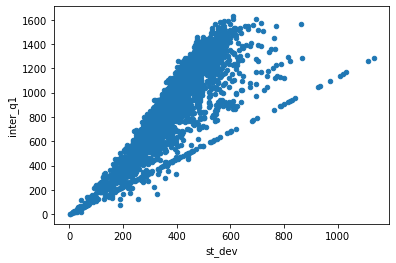

In [8]:
stats.plot.scatter('st_dev', 'inter_q1')

In [9]:
stats['coef_var'] = stats['st_dev'] / stats['mean']

In [10]:
t = ((stats['inter_q1'] - stats['st_dev']) > -0.1) & ((stats['inter_q1'] - stats['st_dev']) < 0.1)
stats[t]

q1      q2      q25      q75      q8      q9  \
branch_id                                                                    
61dee1939132f2fca9ad3e25  1047.1  1047.2  1047.25  1047.75  1047.8  1047.9   
61fb84e97408f35de3371da1   195.1   195.2   195.25   195.75   195.8   195.9   

                            mean    st_dev  size  inter_q1  inter_q2  \
branch_id                                                              
61dee1939132f2fca9ad3e25  1047.5  0.707107     2       0.8       0.6   
61fb84e97408f35de3371da1   195.5  0.707107     2       0.8       0.6   

                          inter_q25  coef_var  
branch_id                                      
61dee1939132f2fca9ad3e25        0.5  0.000675  
61fb84e97408f35de3371da1        0.5  0.003617

<AxesSubplot:>

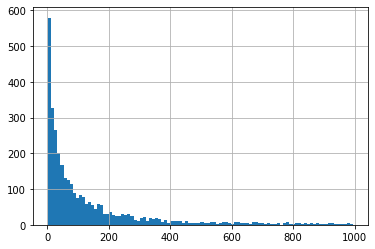

In [11]:
stats[(stats['size'] < 1000) & (stats['size'] > 3)]['size'].hist(bins=100)

In [12]:
m = (stats['mean'] < 1000) & (stats['inter_q1'] < 1000)
df[df['branch_id'].isin(stats[m].index)]['branch_name'].value_counts().head(10)

McDonald's             50078
Snoomart               33659
Hardee's                8136
Oakberry Acai Bowls     4948
Burger King             4911
Krispy Kreme            4244
Subway                  3909
Shawarma El Mama        3823
Hardees                 3758
Grams                   3622
Name: branch_name, dtype: int64

I calculated preparation time as a difference between order creation and order ready status. Seems that there are some dirty values (preparation time more than 6000 sec = 1.6 hour), but after filtering out 5% observations with greatest preparation time we have 30 minutes maximum. Worth noting that here are still some observations with extremely low prep time, thus I filter out prep time less than 30 seconds.

Text(0.5, 1.0, 'Distribution of prep time after filtering')

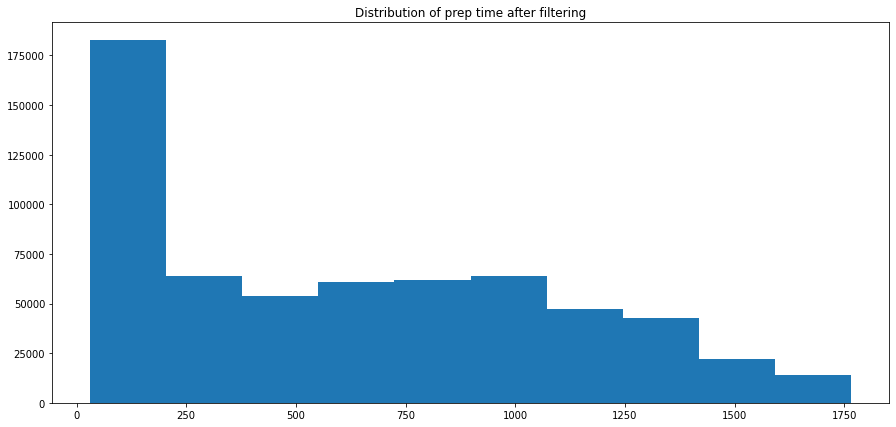

In [13]:
# t = (df['prep_time_sec'] < df['prep_time_sec'].quantile(.95)) & (df['prep_time_sec'] > 30)
plt.figure(figsize=(15, 7))
plt.hist(df['prep_time_sec'])
plt.title('Distribution of prep time after filtering')

In [14]:
tmp = (stats['inter_q1'] / stats['st_dev']).between(1.13, 1.2)
stats[tmp]['size'].value_counts()

2      111
10       2
107      1
9        1
7        1
112      1
52       1
13       1
11       1
27       1
23       1
51       1
14       1
Name: size, dtype: int64

Now we can calculate variance for each restaurant. Calculating standard deviation for the preparation time is straightforward, but I think that interquantile range is also useful in that setting. However standard deviation and interquantile range are correlated.
Also we can see that some branches lie on the line (red line on the graph) those are branches with 2 orders (most of them). Thus I will restrict number of orders to be less than 10.

In [15]:
plt.figure(figsize=(15, 7))

plt.scatter(stats['st_dev'], stats['inter_q2'])
plt.title('Standard deviation vs Interquantile range (20%)')
plt.plot(*[[0, 1000], [0, 830]], c='red')

In [16]:
stats_mask = stats['size'] > 10

Applied all filters we can now show distribution of merchants' preparation time standard deviations. It looks nice - very similar to Normal(371, 91)

In [17]:

plt.figure(figsize=(15, 7))

plt.hist(stats[stats_mask]['st_dev'], bins=20, density=True)
x = np.linspace(50, 650, 100)
plt.plot(x, norm.pdf(x, 371, 91), c='red', label='$\mathcal{N}(371, 91)$')
plt.title("Distribution of merchants' standard deviations")
plt.legend()

Distribution of interquantile ranges looks quite similar

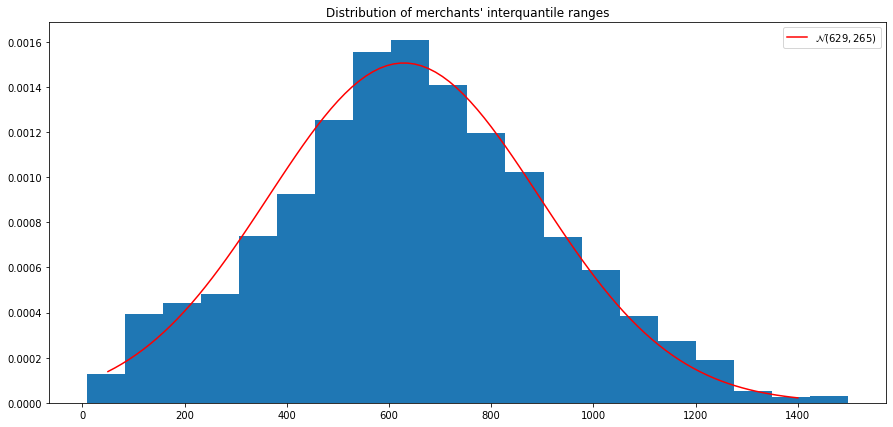

In [18]:
plt.figure(figsize=(15, 7))

plt.hist(stats[stats_mask]['inter_q2'], bins=20, density=True)
x = np.linspace(50, 1400, 100)
plt.plot(x, norm.pdf(x, 629, 265), c='red', label='$\mathcal{N}(629, 265)$')
plt.title("Distribution of merchants' interquantile ranges")
plt.legend()

Text(0.5, 1.0, "Distribution of merchants' coefficient of variation $CV = \\sigma / \\mu$")

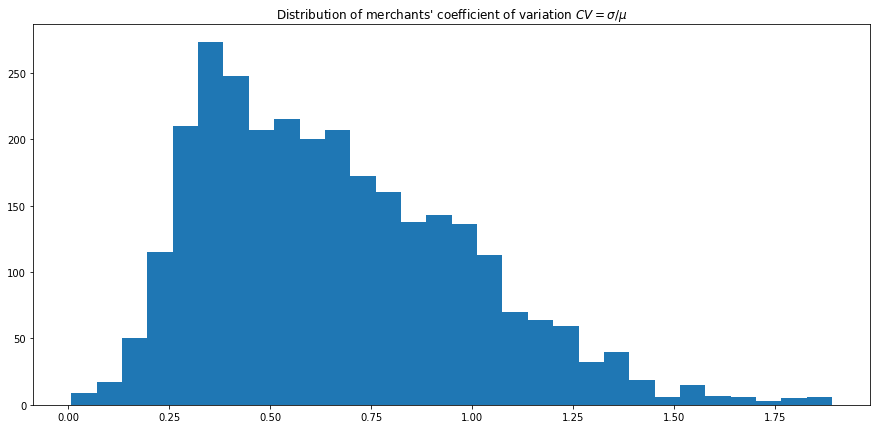

In [27]:
plt.figure(figsize=(15, 7))

plt.hist(stats[stats_mask]['coef_var'], bins=30)
plt.title("Distribution of merchants' coefficient of variation $CV = \sigma / \mu$")

Now we can explore some properties of preparation time.
Here we can expect that variance is growing for merchants wwho have greater preparation time, however this is not true - there is a (inverse) U-shape pattern with low variance for "fast" merchants (as expected) and "slow" merchants (not expected), and higher variance for "middle" merchants.

Text(0.5, 1.0, 'Variance vs average of preparation time (seconds)')

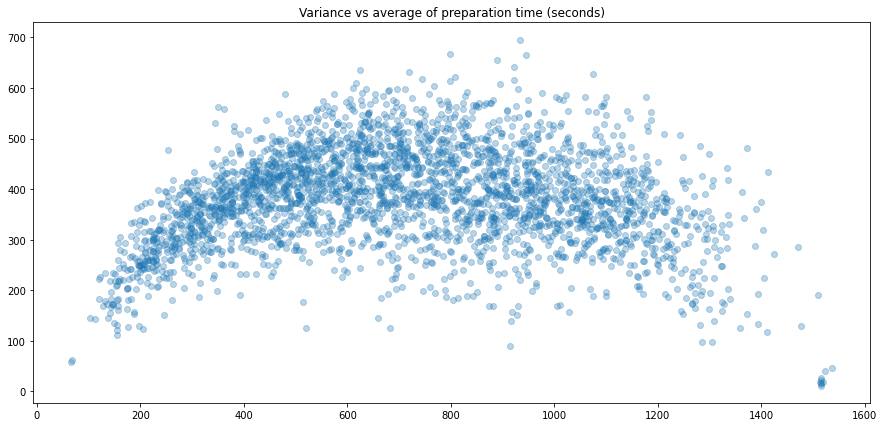

In [28]:
plt.figure(figsize=(15, 7))

plt.scatter(stats[stats_mask]['mean'], stats[stats_mask]['st_dev'], alpha=0.3)
plt.title('Variance vs average of preparation time (seconds)')


Now we can show similar graph in terms of interquantile range. For me it has better explanation than standard deviatiation. Also we can convert them into minutes.
Also we can divide all merchants into 3 groups based on speed (mean preparation time) and stability (interquantile range).
This can help with treating those groups in different ways.

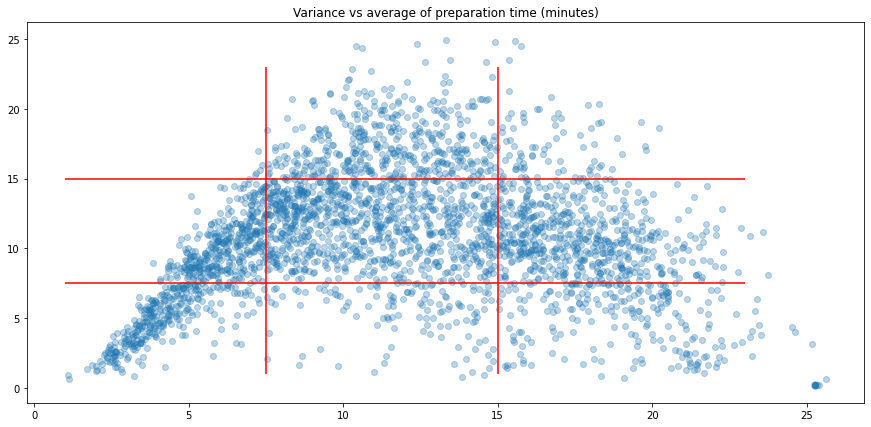

In [29]:
plt.figure(figsize=(15, 7))

plt.scatter(stats[stats_mask]['mean'] / 60, stats[stats_mask]['inter_q2'] / 60, alpha=0.3)
plt.title('Variance vs average of preparation time (minutes)')
plt.vlines([7.5, 15], 1, 23, color='red')
plt.hlines([7.5, 15], 1, 23, color='red')

In [30]:
stats['speed_group'] = pd.cut(stats['mean'] / 60, [0, 7.5, 15, np.inf])
stats['stability_group'] = pd.cut(stats['inter_q2'] / 60, [0, 7.5, 15, np.inf])

stats.loc[~stats_mask, 'speed_group'] = np.nan
stats.loc[~stats_mask, 'stability_group'] = np.nan

stats['speed_stab_group'] = stats[['speed_group', 'stability_group']].apply(tuple, axis=1)

Text(0, 0.5, 'Stability group')

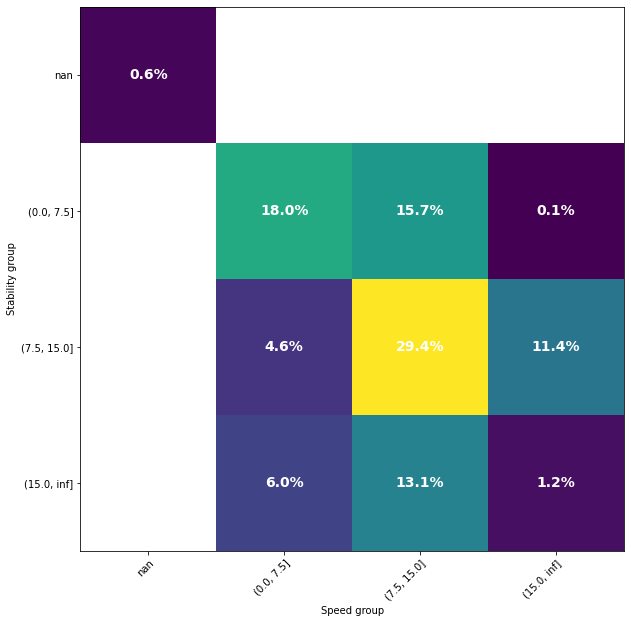

In [36]:
merged = df.merge(stats[['speed_stab_group', 'coef_var']], how='left', left_on='branch_id', right_index=True)

rst = (merged.groupby(['speed_stab_group']).size() / merged.shape[0] * 100).reset_index()
rst['speed_group'] = rst['speed_stab_group'].apply(lambda x: x[0])
rst['stab_group'] = rst['speed_stab_group'].apply(lambda x: x[1])

tmp = rst.set_index(['speed_group', 'stab_group'])[0].unstack()

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(tmp)

ax.set_xticks(np.arange(len(tmp.columns)), labels=tmp.columns)
ax.set_yticks(np.arange(len(tmp.index)), labels=tmp.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(tmp.index)):
    for j in range(len(tmp.columns)):
        text = ax.text(j, i, f'{tmp.values[i, j]:.1f}%',
                       ha="center", va="center", color="w", fontweight=800, fontsize=14)

ax.set_xlabel('Speed group')
ax.set_ylabel('Stability group')

In [37]:
res = {}
for n, g in merged.groupby('speed_stab_group'):
    res[n] = list(g['branch_name'].value_counts().nlargest(5).index)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow([[np.nan] * 3] * 3)

x_lab = sorted(list(set([x[0] for x in res if x[0] is not np.nan])))
y_lab = sorted(list(set([x[1] for x in res if x[1] is not np.nan])))

ax.set_xticks(np.arange(len(x_lab)), labels=x_lab)
ax.set_yticks(np.arange(len(y_lab)), labels=y_lab)

ax.set_xlabel('Speed group')
ax.set_ylabel('Stability group')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(y_lab)):
    for j in range(len(x_lab)):
        text = ax.text(j, i, '\n'.join(res[(y_lab[j], x_lab[i])]),
                       ha="center", va="center", color="black", fontweight=800, fontsize=10)

<AxesSubplot:xlabel='orders_in_10_min'>

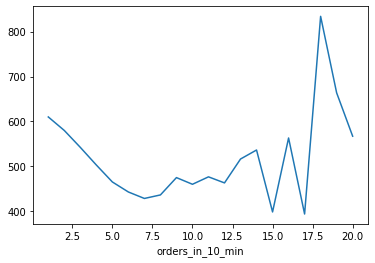

In [38]:
m = df['orders_in_30_min'] > 5
m1 = df['branch_id'].isin(df[m]['branch_id'].unique())
df[m1].groupby('orders_in_10_min')['prep_time_sec'].mean().plot()
# df[m1].groupby('orders_in_30_min')['prep_time_sec'].size().plot()

In [39]:
stats.drop(['stability_group', 'speed_group'], axis=1).to_csv('stats_by_branch_id.csv')

Text(0.5, 1.0, "Distribution of merchants' coefficient of variation $CV = \\sigma / \\mu$")

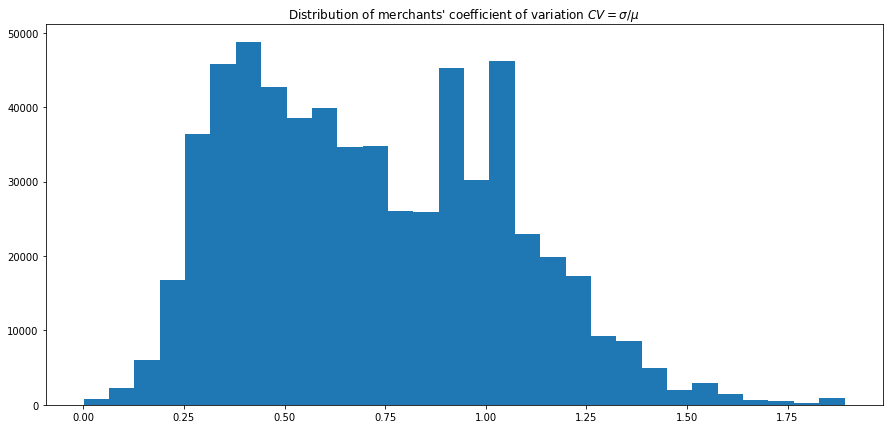

In [43]:
plt.figure(figsize=(15, 7))

plt.hist(merged['coef_var'], bins=30)
plt.title("Distribution of merchants' coefficient of variation $CV = \sigma / \mu$")

In [42]:
merged

order_id                 branch_id                     delivered_at  \
0        6686242  60dc601ef43cd5896d4b11e3 2022-05-25 22:19:32.692191+00:00   
1        6761132  60dc601ef43cd5896d4b11e3 2022-05-29 22:00:03.471068+00:00   
2        6779887  60dc601ef43cd5896d4b11e3 2022-05-31 00:19:36.562596+00:00   
3        6856903  60dc601ef43cd5896d4b11e3 2022-06-05 00:39:46.765327+00:00   
4        6871729  60dc601ef43cd5896d4b11e3 2022-06-06 01:59:03.522270+00:00   
...          ...                       ...                              ...   
612903   7664824  62de93cd606655f3cb1606c5 2022-07-28 14:43:12.919161+00:00   
612904   7673098  62de93cd606655f3cb1606c5 2022-07-28 22:31:57.202282+00:00   
612905   7655994  62dea6c4d71357e425a9e983 2022-07-27 21:11:35.869027+00:00   
612906   7656248  62dea6c4d71357e425a9e983 2022-07-27 21:47:10.185614+00:00   
612907   7657413  62dea6c4d71357e425a9e983 2022-07-27 22:03:20.243876+00:00   

       order_eta  preparation_time                   committed_time  \
0            NaT                18 2022-05-25 22:26:56.823134+00:00   
1            NaT                18 2022-05-29 22:10:02.284956+00:00   
2            NaT                18 2022-05-31 00:24:31.624153+00:00   
3            NaT                18 2022-06-05 00:54:01.063839+00:00   
4            NaT                18 2022-06-06 02:08:32.141693+00:00   
...          ...               ...                              ...   
612903       NaT                22 2022-07-28 14:36:56.773295+00:00   
612904       NaT                22 2022-07-28 22:21:41.209830+00:00   
612905       NaT                22 2022-07-27 21:10:11.336272+00:00   
612906       NaT                22 2022-07-27 21:23:22.490551+00:00   
612907       NaT                22 2022-07-27 22:19:27.900477+00:00   

       order_status order_type  delivery_type  total  ... const  eta_sec  \
0         DELIVERED       Food              1   84.0  ...     1     2142   
1         DELIVERED       Food              1   87.0  ...     1     2364   
2         DELIVERED       Food              1   70.0  ...     1     2342   
3         DELIVERED       Food              1   42.0  ...     1     1891   
4         DELIVERED       Food              1   46.0  ...     1     2345   
...             ...        ...            ...    ...  ...   ...      ...   
612903    DELIVERED       Food              1   62.0  ...     1     2222   
612904    DELIVERED       Food              1   60.0  ...     1     2569   
612905    DELIVERED       Food              1   70.0  ...     1     2457   
612906    DELIVERED       Food              1   75.0  ...     1     2598   
612907    DELIVERED       Food              1   60.0  ...     1     3062   

       rta_sec  prep_time_sec  orders_in_5_min  orders_in_10_min  \
0       1699.0          709.0              1.0               1.0   
1       1766.0          846.0              1.0               1.0   
2       2047.0         1163.0              1.0               1.0   
3       1037.0          351.0              2.0               2.0   
4       1777.0          601.0              1.0               1.0   
...        ...            ...              ...               ...   
612903  2598.0          808.0              1.0               1.0   
612904  3185.0         1335.0              3.0               3.0   
612905  2541.0          275.0              1.0               1.0   
612906  4026.0           47.0              1.0               1.0   
612907  2095.0          357.0              1.0               1.0   

       orders_in_15_min orders_in_30_min           speed_stab_group  coef_var  
0                   1.0              1.0  ((7.5, 15.0], (0.0, 7.5])  0.323145  
1                   1.0              1.0  ((7.5, 15.0], (0.0, 7.5])  0.323145  
2                   1.0              1.0  ((7.5, 15.0], (0.0, 7.5])  0.323145  
3                   2.0              2.0  ((7.5, 15.0], (0.0, 7.5])  0.323145  
4                   1.0              1.0  ((7.5, 15.0], (0.0, 7.5])  0.32314